In [1]:
import barmuscomp.ae_utils as ae_utils
import barmuscomp.ae as ae
import barmuscomp.lra as lra
import barmuscomp.scripts.default_path as paths
import barmuscomp.scripts.overall_scripts as scr

import as_seg.CBM_algorithm as CBM
import as_seg.barwise_input as bi
import as_seg.data_manipulation as dm
import as_seg.autosimilarity_computation as as_comp
#import as_seg.barwise_input as bi
from barmuscomp.model.current_plot import *

import math
import numpy as np
import pandas as pd
import mirdata
import os
import tensorly as tl
import matplotlib

plt.rcParams.update({'font.size': 14})

In [2]:
subdivision = 96
hop_length = 32
hop_length_seconds = hop_length/44100
autosimilarity_type = "cosine"
n_epochs = 1000
feature = "log_mel_grill"
beta = 2
dim_latent_space = 16
latent_nonlinearity = None

In [3]:
def permutate_factor(factor):
    """
    Computes the permutation of columns of the factors for them to be visually more comprehensible.
    """
    permutations = []
    for i in factor:
        idx_max = np.argmax(i)
        if idx_max not in permutations:
            permutations.append(idx_max)
    for i in range(factor.shape[1]):
        if i not in permutations:
            permutations.append(i)
    return permutations

def this_plot_permuted_factor(factor, title = None, x_axis = "Bar indexes", y_axis = "Latent space\ndimensions", cmap = cm.PiYG):
    """
    Plots this factor, but permuted to be easier to understand visually.
    """
    permut = permutate_factor(factor)
    factor_to_plot = factor.T[permut]
    plt.figure(figsize=(factor.shape[0]/10,factor.shape[1]/10))
    heatmap = plt.pcolormesh(np.arange(factor_to_plot.shape[1]), np.arange(factor_to_plot.shape[0]), factor_to_plot, cmap=cmap)#, norm = norm, vmin = vmin, vmax = vmax, shading='auto')
    cbar = plt.colorbar(heatmap, aspect = 10)#, ticks=[-2.5, 0, 2.5, 5])
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.gca().invert_yaxis()
    plt.show()


In [4]:
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    source: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [5]:
song_name = 1
spectrogram, bars, references_segments = scr.load_spec_annot_song_RWC(song_name, feature, hop_length)
tensor_spectrogram = bi.tensorize_barwise_BFT(spectrogram, bars, hop_length_seconds, subdivision)
conv_dataloader = ae_utils.generate_dataloader(tensor_spectrogram, batch_size = None)
triplet_conv_dataloader, _ = ae_utils.generate_triplet_dataloader(tensor_spectrogram, batch_size = None)

Using cpu


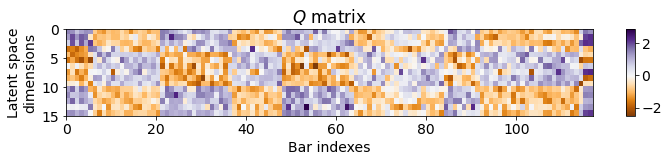

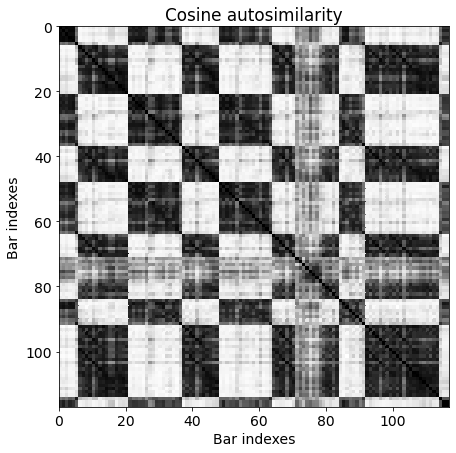

In [6]:
conv_triplet = ae.ConvolutionalAutoencoderTriplet(input_size_x = 96, input_size_y = 80, dim_latent_space = dim_latent_space, beta = beta, latent_nonlinearity = latent_nonlinearity, batch_norm = True, seed = 42)
conv_triplet.my_optim_method(n_epochs = n_epochs, data_loader = triplet_conv_dataloader, lr = 1e-3, tensor_barwise = tensor_spectrogram, early_stop_patience = 100, verbose = False, labels = None)
proj_conv_triplet = conv_triplet.get_latent_projection(triplet_conv_dataloader)
vmax = np.amax(proj_conv_triplet)
vmin = np.amin(proj_conv_triplet)
shiftedcm = shiftedColorMap(cm.PuOr, start=0, midpoint=1 - vmax / (vmax + abs(vmin)), stop=1, name='shiftedcmap')
this_plot_permuted_factor(np.array(proj_conv_triplet), title = "$Q$ matrix", cmap = shiftedcm)
autosimilarity_conv_triplet = as_comp.switch_autosimilarity(proj_conv_triplet, similarity_type = "Cosine", normalise = True)
plot_me_this_spectrogram(autosimilarity_conv_triplet, title = "Cosine autosimilarity", x_axis = "Bar indexes", y_axis = "Bar indexes")

Using cpu


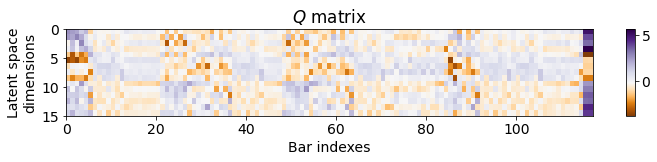

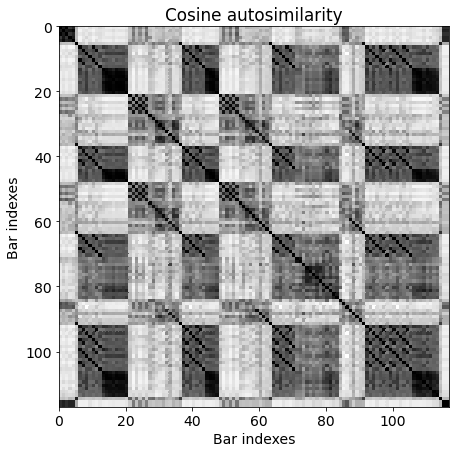

In [8]:
conv = ae.ConvolutionalAutoencoder(input_size_x = 96, input_size_y = 80, dim_latent_space = dim_latent_space, beta = beta, latent_nonlinearity = latent_nonlinearity, batch_norm = True, seed = 42)
conv.my_optim_method(n_epochs = n_epochs, data_loader = conv_dataloader, lr = 1e-3, early_stop_patience = 100, verbose = False, labels = None)
proj_conv = conv.get_latent_projection(conv_dataloader)
vmax = np.amax(proj_conv)
vmin = np.amin(proj_conv)
shiftedcm = shiftedColorMap(cm.PuOr, start=0, midpoint=1 - vmax / (vmax + abs(vmin)), stop=1, name='shiftedcmap')
this_plot_permuted_factor(np.array(proj_conv), title = "$Q$ matrix", cmap = shiftedcm)
autosimilarity_conv = as_comp.switch_autosimilarity(proj_conv, similarity_type = "Cosine", normalise = True)
plot_me_this_spectrogram(autosimilarity_conv, title = "Cosine autosimilarity", x_axis = "Bar indexes", y_axis = "Bar indexes")